# Stock Price Prediction as a Classification Problem
Objective: Predict today's from past n number of days.

Tool: CNTK

NN: Feedforward + relu

In [64]:
import numpy as np
import cntk
import cntk.ops as C

from cntk.blocks import default_options, Input   # Building blocks
from cntk.initializer import glorot_uniform
from cntk.layers import Dense                    # Layers
from cntk.learner import sgd, learning_rate_schedule, UnitType
from cntk.utils import get_train_eval_criterion, get_train_loss, ProgressPrinter, get_train_loss

import datetime
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

### Utility to download stock data from open source

In [65]:
# A method which obtains stock data from Yahoo finance
# Requires that you have an internet connection to retreive stock data from Yahoo finance
try:
    from pandas_datareader import data
except ImportError:
    !pip install pandas_datareader
    from pandas_datareader import data

def get_stock_data(contract, s_year, s_month, s_day, e_year, e_month, e_day):
    """
    Args:
        contract (str): the name of the stock/etf
        s_year (int): start year for data
        s_month (int): start month
        s_day (int): start day
        e_year (int): end year
        e_month (int): end month
        e_day (int): end day
    Returns:
        Pandas Dataframe: Daily OHLCV bars
    """
    start = datetime.datetime(s_year, s_month, s_day)
    end = datetime.datetime(e_year, e_month, e_day)
    bars = data.get_data_yahoo(contract, start, end)
    return bars

In [66]:
data = get_stock_data("MSFT", 2000,1,2,2016,12,1)
data.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2000-01-03,117.3750,118.625,112.0000,116.5625,53228400,39.573098
2000-01-04,113.5625,117.125,112.2500,112.6250,54119000,38.236313
2000-01-05,111.1250,116.375,109.3750,113.8125,64059600,38.639470
2000-01-06,112.1875,113.875,108.3750,110.0000,54976600,37.345122
2000-01-07,108.6250,112.250,107.3125,111.4375,62013600,37.833155


In [67]:
#type(data)
#data.shape
#data['Open']
#data.axes
data['2000-01-03':'2000-01-10']['Open']

Date
2000-01-03    117.3750
2000-01-04    113.5625
2000-01-05    111.1250
2000-01-06    112.1875
2000-01-07    108.6250
2000-01-10    113.4375
Name: Open, dtype: float64

### Plot downloaded data

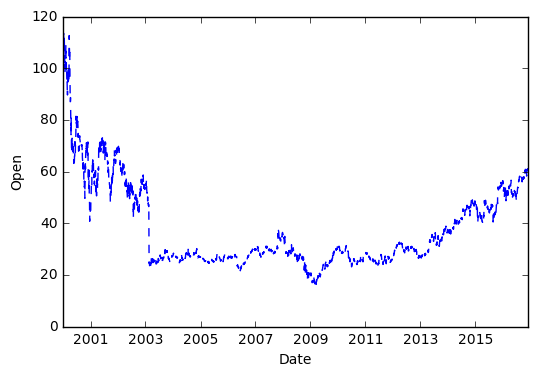

In [68]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot(data[:]['Open'], 'b--'); # plt.plot(data['2000-01-03':'2001-01-03']['Open'], 'b--')
plt.xlabel('Date')
plt.ylabel('Open')
plt.show()

### Create features from raw data

In [116]:
#feature name List
predictor_names = []

# price difference as percentage, fill NA with 0
data['price_diff_percent'] = np.abs((data['Close'] - data['Close'].shift(1))/data['Close']).fillna(0) # fill NA with 0
predictor_names.append('price_diff_percent')

# volume difference as percentage, fill NA with 0
data['vol_diff_percent'] = np.abs((data['Volume'] - data['Volume'].shift(1))/data['Volume']).fillna(0) # fill NA with 0
predictor_names.append('vol_diff_percent')

# give label such that up is 1, same or down is 0 
# TODO: up is 2, same is 1 or down is 0
num_days_back = 7

for i in range(1, num_days_back+1):
    data['lookback_' + str(i)] = np.where(data['Close'] > data['Close'].shift(i), 1, 0)
    predictor_names.append('lookback_' + str(i))
    

    

In [117]:
data.head()

,Open,High,Low,Close,Volume,Adj Close,diff,v_diff,back_1,back_2,...,next_day_opposite,price_diff_percent,vol_diff_percent,lookback_1,lookback_2,lookback_3,lookback_4,lookback_5,lookback_6,lookback_7
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,117.3750,118.625,112.0000,116.5625,53228400,39.573098,0.000000,0.000000,0,0,...,1,0.000000,0.000000,0,0,0,0,0,0,0
2000-01-04,113.5625,117.125,112.2500,112.6250,54119000,38.236313,0.034961,0.016456,0,0,...,0,0.034961,0.016456,0,0,0,0,0,0,0
2000-01-05,111.1250,116.375,109.3750,113.8125,64059600,38.639470,0.010434,0.155177,1,0,...,1,0.010434,0.155177,1,0,0,0,0,0,0
2000-01-06,112.1875,113.875,108.3750,110.0000,54976600,37.345122,0.034659,0.165216,0,0,...,0,0.034659,0.165216,0,0,0,0,0,0,0
2000-01-07,108.6250,112.250,107.3125,111.4375,62013600,37.833155,0.012900,0.113475,1,0,...,0,0.012900,0.113475,1,0,0,0,0,0,0


In [118]:
# save data
filename = './data/feature.tsv'
data.to_csv(filename, sep='\t')

### Prepare label

In [119]:
# prepare the prediction, i.e. label
data['next_day'] = np.where(data['Close'].shift(-1)>data['Close'], 1, 0) # put in today * see 'Some nitty gritty'
data['next_day_opposite'] = np.where(data['next_day'] == 1, 0, 1) # why reverse it? Will turn into 1-hot. see *'Preparing training and testing data'
print(data['next_day'].head())
print(data['next_day_opposite'].head())

Date
2000-01-03    0
2000-01-04    1
2000-01-05    0
2000-01-06    1
2000-01-07    1
Name: next_day, dtype: int32
Date
2000-01-03    1
2000-01-04    0
2000-01-05    1
2000-01-06    0
2000-01-07    0
Name: next_day_opposite, dtype: int32


### Prepare training data and test data

In [125]:
test_data = data['2015-01-03':][predictor_names]; print(test_data.head())
print(test_data.shape)
training_data = data['2000-01-03':'2015-01-02']
training_features = np.asarray(training_data[predictor_names], dtype='float32'); print(training_features[:5])
training_labels = np.asarray(training_data[['next_day', 'next_day_opposite']], dtype='float32'); print(training_labels[:5])
print(training_features.shape)
print(training_labels.shape)


            price_diff_percent  vol_diff_percent  lookback_1  lookback_2  \
Date                                                                       
2015-01-05            0.009281          0.296417           0           0   
2015-01-06            0.014896          0.088510           0           0   
2015-01-07            0.012546          0.251899           1           0   
2015-01-08            0.028577          0.017915           1           1   
2015-01-09            0.008476          0.238095           0           1   

            lookback_3  lookback_4  lookback_5  lookback_6  lookback_7  
Date                                                                    
2015-01-05           0           0           0           0           0  
2015-01-06           0           0           0           0           0  
2015-01-07           0           0           0           0           0  
2015-01-08           1           1           1           1           1  
2015-01-09           1       

### Build the Network

In [128]:
input_dim = 2 + num_days_back # the 2 are: price_diff_percent  vol_diff_percent  
num_output_classes = 2 # up is 1, down or neutral is 0
num_hidden_layers = 2
hidden_layers_dim = 50 # number of nodes per layer

# Define container using Input()
input = Input(input_dim)
label = Input(num_output_classes)

# Network architecture
def create_model(input, num_output_classes):
    h = input
    for i in range(0, num_hidden_layers):
        h = Dense(hidden_layers_dim, init=glorot_uniform(), activation = C.relu)(h)
    return(Dense(num_output_classes, init=glorot_uniform(), activation = None)(h))

z = create_model(input, num_output_classes)

loss = C.cross_entropy_with_softmax(z, label)
label_error = C.classification_error(z, label)

lr_per_minibatch = learning_rate_schedule(0.125, UnitType.minibatch)

trainer = cntk.Trainer(z, loss, label_error, [sgd(z.parameters, lr=lr_per_minibatch)])

### Initialize the parameters for the trainer

In [135]:
minibatch_size = 100
num_minibatches = len(training_data.index) // minibatch_size; #print(num_minibatches) -> 37

training_progress_output_freq = 1

plotdata = {'batchsize':[], 'loss':[], 'error':[]}

### Utility to print training progress

In [148]:
def print_training_progress(trainer, mb, frequency, verbose=1):
    training_loss = 'NA'
    eval_error = 'NA'
    if mb%frequency == 0:
        training_loss = get_train_loss(trainer) #cntk function
        eval_error = get_train_eval_criterion(trainer) #cntk function
        if verbose:
            print('Minibatch:{0}, Loss: {1:.4f}, Error: {2:.2f}%'.format(mb, training_loss, eval_error))
                 # Minibatch:0, Loss: 0.6968, Error: 0.51%
            
    return mb, training_loss, eval_error

### Explicitly split the training sequence

In [146]:
tf = np.split(training_features, num_minibatches); print(len(tf)); print(tf[0].shape) 
tl = np.split(training_labels, num_minibatches); print(len(tl)); print(tl[0].shape)  
# print the first sequence 
print(tf[0]) # 37 mini batches, each batch with 102 rows
print(tl[0])

37
(102, 9)
37
(102, 2)
[[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  3.49611528e-02   1.64563283e-02   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  1.04338275e-02   1.55177370e-01   1.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  3.46590914e-02   1.65215746e-01   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  1.28996074e-02   1.13475107e-01   1.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  7.23830750e-03   3.79195631e-01   1.00000000e+00   1.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  2.62857135e-

### Train the NN

In [154]:
# Only 1 pass through the data linearly in time
num_passes = 1

#print(num_minibatches*num_passes) 

for i in range(num_minibatches*num_passes): # num_minibatches*num_passes = 37*1
    features = np.ascontiguousarray(tf[i%num_minibatches]) # http://stackoverflow.com/questions/26998223/what-is-the-difference-between-contiguous-and-non-contiguous-arrays
    labels = np.ascontiguousarray(tl[i%num_minibatches])
    #print(i%num_minibatches)
    
    #Specify the mapping of input variables in the model to actual minibatch data to be trained with
    trainer.train_minibatch({input:features, label:labels})
    batchsize, loss, error = print_training_progress(trainer, i, training_progress_output_freq)
    
    if not (loss == 'NA' or error == 'NA'):
            plotdata['batchsize'].append(batchsize)
            plotdata['loss'].append(loss)
            plotdata['error'].append(error)

Minibatch:0, Loss: 0.6968, Error: 0.51%
Minibatch:1, Loss: 1.3236, Error: 0.44%
Minibatch:2, Loss: 30.4543, Error: 0.51%
Minibatch:3, Loss: 11.4619, Error: 0.47%
Minibatch:4, Loss: 407.2903, Error: 0.43%
Minibatch:5, Loss: 1293.5002, Error: 0.46%
Minibatch:6, Loss: 1469.4928, Error: 0.50%
Minibatch:7, Loss: 2.1145, Error: 0.44%
Minibatch:8, Loss: 3.0104, Error: 0.48%
Minibatch:9, Loss: 3.2049, Error: 0.54%
Minibatch:10, Loss: 4.3280, Error: 0.56%
Minibatch:11, Loss: 3.4399, Error: 0.53%
Minibatch:12, Loss: 4.0307, Error: 0.58%
Minibatch:13, Loss: 3.9561, Error: 0.51%
Minibatch:14, Loss: 2.9279, Error: 0.56%
Minibatch:15, Loss: 3.8326, Error: 0.43%
Minibatch:16, Loss: 0.9839, Error: 0.41%
Minibatch:17, Loss: 2.7662, Error: 0.49%
Minibatch:18, Loss: 3.3879, Error: 0.50%
Minibatch:19, Loss: 2.8014, Error: 0.47%
Minibatch:20, Loss: 3.3477, Error: 0.56%
Minibatch:21, Loss: 3.4571, Error: 0.42%
Minibatch:22, Loss: 1.3722, Error: 0.51%
Minibatch:23, Loss: 4.9736, Error: 0.58%
Minibatch:24, Lo

### Plot training progress

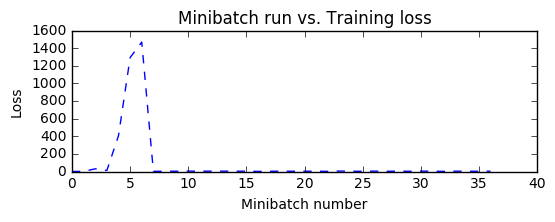

In [155]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.subplot(211)
plt.plot(plotdata['batchsize'], plotdata['loss'], 'b--')
plt.xlabel('Minibatch number')
plt.ylabel('Loss')
plt.title('Minibatch run vs. Training loss')
plt.show()

### Some nitty gritty

In [97]:
# 2000-01-03 - 2000-01-04 // tomorrow - today
print(data['2000-01-03': '2000-01-10']['Close'] - data['2000-01-03': '2000-01-10']['Close'].shift(1))
# 2000-01-03 - 2000-01-04 // today - tomorrow
print(data['2000-01-03': '2000-01-10']['Close'].shift(1) - data['2000-01-03': '2000-01-10']['Close']) # put in tomorrow
print(data['2000-01-03': '2000-01-10']['Close'] - data['2000-01-03': '2000-01-10']['Close'].shift(-1)) # put in today

Date
2000-01-03       NaN
2000-01-04   -3.9375
2000-01-05    1.1875
2000-01-06   -3.8125
2000-01-07    1.4375
2000-01-10    0.8125
Name: Close, dtype: float64
Date
2000-01-03       NaN
2000-01-04    3.9375
2000-01-05   -1.1875
2000-01-06    3.8125
2000-01-07   -1.4375
2000-01-10   -0.8125
Name: Close, dtype: float64
Date
2000-01-03    3.9375
2000-01-04   -1.1875
2000-01-05    3.8125
2000-01-06   -1.4375
2000-01-07   -0.8125
2000-01-10       NaN
Name: Close, dtype: float64


In [98]:
data['2000-01-03': '2000-01-10']['Close']

Date
2000-01-03    116.5625
2000-01-04    112.6250
2000-01-05    113.8125
2000-01-06    110.0000
2000-01-07    111.4375
2000-01-10    112.2500
Name: Close, dtype: float64

In [99]:
data['2000-01-03': '2000-01-10']['Close'].shift(1)

Date
2000-01-03         NaN
2000-01-04    116.5625
2000-01-05    112.6250
2000-01-06    113.8125
2000-01-07    110.0000
2000-01-10    111.4375
Name: Close, dtype: float64

In [100]:
data['2000-01-03': '2000-01-10']['Close'].shift(-1)

Date
2000-01-03    112.6250
2000-01-04    113.8125
2000-01-05    110.0000
2000-01-06    111.4375
2000-01-07    112.2500
2000-01-10         NaN
Name: Close, dtype: float64

In [133]:
num_minibatches = len(training_data.index) / minibatch_size; print(num_minibatches)
num_minibatches = len(training_data.index) // minibatch_size; print(num_minibatches)

37.74
37
